In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ray
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.1/68.1 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 23.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" a

In [ ]:
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from ray import tune
import json

# Load dataset from JSON
df = pd.read_json("/content/drive/MyDrive/TTTT-comments_sentiment-emojis (1).json", lines=True)  # Use lines=True if NDJSON

# Preprocess the data
def preprocess_data(df):
    df = df[["Comment", "Sentiment"]]
    df = df.dropna()
    sentiment_mapping = {"Negative": 0, "Neutral": 1, "Positive": 2}
    df["Sentiment"] = df["Sentiment"].map(sentiment_mapping)
    return df

df = preprocess_data(df)

# Split your DataFrame into train and test datasets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["Comment"].tolist(), df["Sentiment"].tolist(), test_size=0.2, random_state=42
)


In [ ]:
# Step 1: Split your DataFrame into train and test datasets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['Comment'].tolist(), df['Sentiment'].tolist(), test_size=0.2, random_state=42
)


# Step 2: Convert the lists into Hugging Face Dataset objects
train_dataset = Dataset.from_dict({'Comment': train_texts, 'Sentiment': train_labels})
test_dataset = Dataset.from_dict({'Comment': test_texts, 'Sentiment': test_labels})

In [ ]:

# Step 3: Initialize tokenizer (use your model's tokenizer)
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the datasets
def tokenize_function(examples):
    return tokenizer(examples['Comment'], padding='max_length', truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch (ensure 'sentiment' column is treated as 'labels')
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'Sentiment'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'Sentiment'])

# Rename 'sentiment' column to 'labels' for the Trainer
train_dataset = train_dataset.rename_column('Sentiment', 'labels')
test_dataset = test_dataset.rename_column('Sentiment', 'labels')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/1440 [00:00<?, ? examples/s]

Map:   0%|          | 0/361 [00:00<?, ? examples/s]

In [ ]:
def model_init():
    return BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

def compute_metrics(p):
    preds = torch.argmax(torch.tensor(p.predictions), axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted')
    acc = accuracy_score(p.label_ids, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 23.8 MB/s eta 0:00:00


In [ ]:
pip install --upgrade transformers


In [ ]:
import optuna
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score

def objective(trial):
    # Define hyperparameters
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)
    batch_size = trial.suggest_categorical('per_device_train_batch_size', [4, 8, 16, 32])
    num_epochs = trial.suggest_int('num_train_epochs', 3, 5)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 0.1)

    # Setup training arguments without dropout_rate
    training_args = TrainingArguments(
        output_dir="/content/drive/MyDrive/PIDEV/sentiment_analysis/final_results",  # Directory to save model outputs
        eval_strategy="epoch",   # Evaluate after each epoch
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_epochs,
        weight_decay=weight_decay,
        logging_dir="/content/drive/MyDrive/PIDEV/sentiment_analysis/final_logs",
        logging_steps=10,
        save_steps=500,
        save_strategy="epoch",         # Save the model after each epoch
        load_best_model_at_end=True,
    )

    # Initialize the model with dropout rate
    model = model_init()  # Use the model defined earlier

    # Initialize the Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
    )

    # Train the model
    trainer.train()

    # Evaluate the model
    eval_results = trainer.evaluate()
    eval_accuracy = eval_results.get('eval_accuracy', 0)

    # Return accuracy as the metric to optimize
    return eval_accuracy


    # Initialize the model (this ensures that the model is fresh for each trial)
    model = model_init()  # Ensure model_init is defined to initialize a fresh model each time

    # Initialize the Trainer with the custom model and training arguments
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,  # Ensure this function is defined for evaluation
    )

    # Train the model
    trainer.train()

    # Evaluate the model on the validation dataset
    eval_results = trainer.evaluate()
    eval_accuracy = eval_results.get('eval_accuracy', 0)  # Default to 0 if accuracy not available

    # Return the evaluation metric (can use accuracy, loss, etc.)
    return eval_accuracy
    # Step 4: Initialize the model
#final_model = model_init()  # Ensure model_init is defined

# Manually define hyperparameters
#learning_rate = 2e-5
#num_train_epochs = 3
#weight_decay = 0.01

# Define the training arguments using manually defined hyperparameters
#final_training_args = TrainingArguments(
 #   output_dir="./final_results",
  #  evaluation_strategy="epoch",
   # learning_rate=learning_rate,
    #per_device_train_batch_size=4,
#    per_device_eval_batch_size=4,
 #   num_train_epochs=num_train_epochs,
  #  weight_decay=weight_decay,
   # logging_dir="./final_logs",
    #logging_steps=10
#)


# Initialize the Trainer
#final_trainer = Trainer(
 #   model=final_model,
  #  args=final_training_args,
   # train_dataset=train_dataset,
    #eval_dataset=test_dataset,
    #compute_metrics=compute_metrics,  # Define this function
#)


In [ ]:
# Create an Optuna study to optimize the accuracy
study = optuna.create_study(direction="maximize")  # Maximize accuracy

# Optimize the objective function (10 trials in this case)
study.optimize(objective, n_trials=10)

# Print the best hyperparameters found by Optuna
print("Best hyperparameters:", study.best_params)


[I 2025-04-27 02:49:33,573] A new study created in memory with name: no-name-1f7f84cd-1021-4265-a674-b94d07181bb0
<ipython-input-23-6758ffa7e23f>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)
<ipython-input-23-6758ffa7e23f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 0.1)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it fo

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.622100,0.597951,0.775623,0.778633,0.789179,0.775623
2,0.438700,0.750620,0.747922,0.745870,0.744962,0.747922
3,0.089900,0.904738,0.775623,0.775336,0.779097,0.775623


[I 2025-04-27 02:57:04,299] Trial 0 finished with value: 0.775623268698061 and parameters: {'learning_rate': 4.362383890882467e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 3, 'weight_decay': 0.029710838015537075}. Best is trial 0 with value: 0.775623268698061.
<ipython-input-23-6758ffa7e23f>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)
<ipython-input-23-6758ffa7e23f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 0.1)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-ba

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.576200,0.653668,0.731302,0.733005,0.739844,0.731302
2,0.427800,0.648650,0.747922,0.747220,0.750040,0.747922
3,0.183100,0.808089,0.734072,0.734685,0.740728,0.734072
4,0.138100,0.923268,0.745152,0.746751,0.750052,0.745152


[I 2025-04-27 03:07:02,463] Trial 1 finished with value: 0.7479224376731302 and parameters: {'learning_rate': 4.0956929363628595e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 4, 'weight_decay': 0.0017712470236580596}. Best is trial 0 with value: 0.775623268698061.
<ipython-input-23-6758ffa7e23f>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)
<ipython-input-23-6758ffa7e23f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 0.1)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ber

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.572300,0.581426,0.756233,0.758525,0.774835,0.756233
2,0.373000,0.726895,0.753463,0.749656,0.749921,0.753463
3,0.111700,0.864346,0.764543,0.765108,0.766096,0.764543
4,0.143400,0.990538,0.761773,0.762765,0.764510,0.761773


[I 2025-04-27 03:17:06,409] Trial 2 finished with value: 0.7562326869806094 and parameters: {'learning_rate': 2.2379977644630833e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 4, 'weight_decay': 7.62315921355387e-05}. Best is trial 0 with value: 0.775623268698061.
<ipython-input-23-6758ffa7e23f>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)
<ipython-input-23-6758ffa7e23f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 0.1)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.729800,0.668646,0.761773,0.763683,0.769879,0.761773
2,0.528600,0.913718,0.767313,0.771420,0.782974,0.767313
3,0.136100,1.327130,0.767313,0.769632,0.776033,0.767313
4,0.350100,1.369978,0.750693,0.750314,0.751757,0.750693
5,0.001200,1.390299,0.764543,0.765340,0.766460,0.764543


[I 2025-04-27 03:30:40,815] Trial 3 finished with value: 0.7617728531855956 and parameters: {'learning_rate': 3.179297254584002e-05, 'per_device_train_batch_size': 4, 'num_train_epochs': 5, 'weight_decay': 0.0004047435956427489}. Best is trial 0 with value: 0.775623268698061.
<ipython-input-23-6758ffa7e23f>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)
<ipython-input-23-6758ffa7e23f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 0.1)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.798500,0.653975,0.734072,0.738695,0.749155,0.734072
2,0.284800,1.061046,0.764543,0.765661,0.770233,0.764543
3,0.004700,1.170748,0.759003,0.759343,0.761145,0.759003


[I 2025-04-27 03:39:01,060] Trial 4 finished with value: 0.7340720221606648 and parameters: {'learning_rate': 4.080647983344443e-05, 'per_device_train_batch_size': 4, 'num_train_epochs': 3, 'weight_decay': 3.0991914150289675e-05}. Best is trial 0 with value: 0.775623268698061.
<ipython-input-23-6758ffa7e23f>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)
<ipython-input-23-6758ffa7e23f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 0.1)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.950500,0.926734,0.601108,0.588540,0.611464,0.601108
2,0.754500,0.765827,0.678670,0.673475,0.672310,0.678670
3,0.664300,0.706228,0.725762,0.724288,0.725217,0.725762
4,0.590200,0.704828,0.709141,0.705429,0.707106,0.709141


[I 2025-04-27 03:48:46,264] Trial 5 finished with value: 0.7091412742382271 and parameters: {'learning_rate': 1.2416267109223511e-05, 'per_device_train_batch_size': 32, 'num_train_epochs': 4, 'weight_decay': 3.742024609615639e-05}. Best is trial 0 with value: 0.775623268698061.
<ipython-input-23-6758ffa7e23f>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)
<ipython-input-23-6758ffa7e23f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 0.1)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ber

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.627400,0.643233,0.756233,0.758979,0.765134,0.756233
2,0.399100,0.963535,0.759003,0.760033,0.762371,0.759003
3,0.008100,1.422261,0.747922,0.750724,0.761331,0.747922
4,0.345900,1.363798,0.753463,0.752562,0.752218,0.753463


[I 2025-04-27 04:00:02,451] Trial 6 finished with value: 0.7562326869806094 and parameters: {'learning_rate': 4.249331281129393e-05, 'per_device_train_batch_size': 4, 'num_train_epochs': 4, 'weight_decay': 0.010910079481977416}. Best is trial 0 with value: 0.775623268698061.
<ipython-input-23-6758ffa7e23f>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)
<ipython-input-23-6758ffa7e23f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 0.1)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-b

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.596500,0.589876,0.764543,0.763882,0.763757,0.764543
2,0.395400,0.656423,0.772853,0.770445,0.769995,0.772853
3,0.085000,0.847230,0.767313,0.767524,0.767813,0.767313
4,0.184800,1.063428,0.756233,0.756523,0.757040,0.756233
5,0.010900,1.134872,0.736842,0.739449,0.744253,0.736842


[I 2025-04-27 04:12:31,772] Trial 7 finished with value: 0.7645429362880887 and parameters: {'learning_rate': 1.725935745434629e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 5, 'weight_decay': 0.0011902075075212511}. Best is trial 0 with value: 0.775623268698061.
<ipython-input-23-6758ffa7e23f>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)
<ipython-input-23-6758ffa7e23f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 0.1)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.550900,0.623120,0.745152,0.746824,0.749660,0.745152
2,0.480000,0.719117,0.747922,0.748237,0.749228,0.747922
3,0.015200,1.080363,0.734072,0.738509,0.752017,0.734072
4,0.318400,1.177121,0.753463,0.753161,0.757105,0.753463
5,0.003000,1.253923,0.767313,0.769551,0.776394,0.767313


[I 2025-04-27 04:25:31,557] Trial 8 finished with value: 0.7451523545706371 and parameters: {'learning_rate': 2.827691572584225e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 5, 'weight_decay': 0.00061959560619279}. Best is trial 0 with value: 0.775623268698061.
<ipython-input-23-6758ffa7e23f>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-5)
<ipython-input-23-6758ffa7e23f>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 0.1)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-ba

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.695600,0.725325,0.714681,0.701948,0.722501,0.714681
2,0.472500,0.620870,0.761773,0.761658,0.762177,0.761773
3,0.225300,0.681272,0.764543,0.765976,0.768535,0.764543
4,0.184800,0.733435,0.756233,0.756608,0.757096,0.756233


[I 2025-04-27 04:35:43,276] Trial 9 finished with value: 0.7617728531855956 and parameters: {'learning_rate': 2.8407413388350645e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 4, 'weight_decay': 1.2512287017311785e-05}. Best is trial 0 with value: 0.775623268698061.


Best hyperparameters: {'learning_rate': 4.362383890882467e-05, 'per_device_train_batch_size': 8, 'num_train_epochs': 3, 'weight_decay': 0.029710838015537075}


In [ ]:
# Get the best hyperparameters
best_params = study.best_params

# Reinitialize model and training arguments using the best parameters
final_model = model_init()

final_training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/PIDEV/sentiment_analysis/final_results",
    eval_strategy="epoch",
    learning_rate=best_params['learning_rate'],
    per_device_train_batch_size=best_params['per_device_train_batch_size'],
    per_device_eval_batch_size=best_params['per_device_train_batch_size'],
    num_train_epochs=best_params['num_train_epochs'],
    weight_decay=best_params['weight_decay'],
    logging_dir="/content/drive/MyDrive/PIDEV/sentiment_analysis/final_logs",
    logging_steps=10,
    save_steps=500,
    load_best_model_at_end=True,
)

# Initialize Trainer again
final_trainer = Trainer(
    model=final_model,
    args=final_training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Train the model with the best hyperparameters
final_trainer.train()



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: --load_best_model_at_end requires the save and eval strategy to match, but found
- Evaluation strategy: IntervalStrategy.EPOCH
- Save strategy: SaveStrategy.STEPS

In [ ]:
# Get the best hyperparameters
best_params = study.best_params

# Reinitialize model and training arguments using the best parameters
final_model = model_init()  # Ensure model_init is defined

final_training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/PIDEV/sentiment_analysis/final_results",
    eval_strategy="epoch",   # Evaluate after each epoch
    learning_rate=best_params['learning_rate'],
    per_device_train_batch_size=best_params['per_device_train_batch_size'],
    per_device_eval_batch_size=best_params['per_device_train_batch_size'],
    num_train_epochs=best_params['num_train_epochs'],
    weight_decay=best_params['weight_decay'],
    logging_dir="/content/drive/MyDrive/PIDEV/sentiment_analysis/final_logs",
    logging_steps=10,
    save_steps=500,
    save_strategy="epoch",   # Save the model after each epoch (must match eval_strategy)
    load_best_model_at_end=True,  # Load the best model at the end of training
)


# Initialize Trainer again with best parameters
final_trainer = Trainer(
    model=final_model,
    args=final_training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

# Train the model with the best hyperparameters
final_trainer.train()

# Optionally save the final model
final_model.save_pretrained("/content/drive/MyDrive/PIDEV/sentiment_analysis/final_model")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.608500,0.588151,0.772853,0.773416,0.774263,0.772853
2,0.491600,0.820835,0.778393,0.777258,0.777335,0.778393
3,0.014800,0.961650,0.764543,0.764455,0.765372,0.764543


In [ ]:
# Save the model and tokenizer using the correct methods
model_save_path = "/content/drive/MyDrive/PIDEV/sentiment_analysis/final_model_a"

# Save the model
final_model.save_pretrained(model_save_path)  # Save the model with Hugging Face method

# Save the tokenizer (if you're using a tokenizer)
tokenizer.save_pretrained(model_save_path)  # Save the tokenizer


('/content/drive/MyDrive/PIDEV/sentiment_analysis/final_model_a/tokenizer_config.json',
 '/content/drive/MyDrive/PIDEV/sentiment_analysis/final_model_a/special_tokens_map.json',
 '/content/drive/MyDrive/PIDEV/sentiment_analysis/final_model_a/vocab.txt',
 '/content/drive/MyDrive/PIDEV/sentiment_analysis/final_model_a/added_tokens.json',
 '/content/drive/MyDrive/PIDEV/sentiment_analysis/final_model_a/tokenizer.json')

In [ ]:

# Evaluate the model
final_results = final_trainer.evaluate()
print(final_results)

{'eval_loss': 0.5881509780883789, 'eval_accuracy': 0.7728531855955678, 'eval_f1': 0.7734158108122438, 'eval_precision': 0.7742630777249601, 'eval_recall': 0.7728531855955678, 'eval_runtime': 10.3566, 'eval_samples_per_second': 34.857, 'eval_steps_per_second': 4.442, 'epoch': 3.0}


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(p):
    predictions, labels = p
    preds = predictions.argmax(axis=-1)  # Assuming a classification task
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')  # Adjust based on your use case
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


In [ ]:
# Step 6: Run inference on the first 5 test samples
test_samples = test_dataset.select(range(5))

# Run inference
predictions = final_trainer.predict(test_samples)
# Extract logits and get the predicted labels
logits = predictions.predictions
predicted_labels = logits.argmax(axis=-1)

# Print the predictions and true labels
print("Predicted Labels:", predicted_labels)
print("True Labels:", predictions.label_ids)

Predicted Labels: [1 2 1 0 2]
True Labels: [1 2 0 1 2]


In [ ]:
# Step 5: Run training (if not already done)
final_trainer.train()

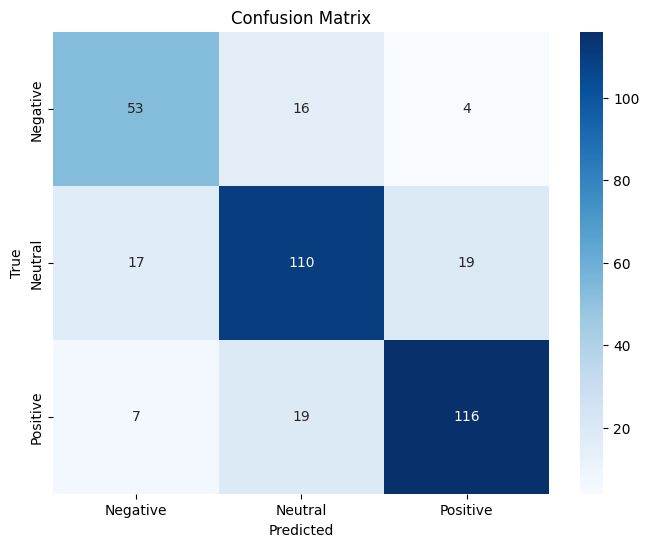

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get the predictions from your trained model
predictions = final_trainer.predict(test_dataset)  # Ensure `test_dataset` is your evaluation dataset

# Extract the predicted labels (logits -> predicted labels)
pred_labels = np.argmax(predictions.predictions, axis=1)

# Get the true labels from the evaluation dataset
true_labels = predictions.label_ids

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Class labels for positive, negative, and neutral
class_names = ['Negative', 'Neutral', 'Positive']

# Plot the confusion matrix using seaborn for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
